In [1]:
# %%
import os
import sys
import torch
import numpy as np
import librosa
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ASTForAudioClassification, ASTFeatureExtractor
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

/Users/jaewone/ENTER/envs/tf24/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# %%
# Settings: target animal and data path
target_animal = 'dog'  # 'cat' or 'dog'

# Set paths
main_path = os.path.join(os.getcwd().rsplit(
    'FurEmotion-AI')[0], 'FurEmotion-AI')
data_path = os.path.join(main_path, 'data', target_animal)

sys.path.append(main_path)

if not os.path.exists(data_path):
    raise ValueError(f'No such animal data path: {data_path}')

state_list = [dir_path for dir_path in os.listdir(
    data_path) if os.path.isdir(os.path.join(data_path, dir_path))]
print(f"List of states to classify: {state_list}")

num_classes = len(state_list)

List of states to classify: ['relax', 'hostile', 'whining']


In [3]:
# Collect data and labels
data = []
labels = []

for idx, state in enumerate(state_list):
    state_path = os.path.join(data_path, state)
    for root, dirs, files in os.walk(state_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                # Load audio file
                wave, sr = librosa.load(file_path, mono=True, sr=16000)
                data.append(wave)
                labels.append(idx)

# %%
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42)

In [4]:
# Load feature extractor
feature_extractor = ASTFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593")

# Create custom dataset


class AudioDataset(Dataset):
    def __init__(self, audio_list, labels, feature_extractor):
        self.audio_list = audio_list
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.audio_list)

    def __getitem__(self, idx):
        audio = self.audio_list[idx]
        label = self.labels[idx]
        # Process audio
        inputs = self.feature_extractor(
            audio, sampling_rate=16000, return_tensors="pt", padding=True)
        return {
            'input_values': inputs['input_values'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Create datasets and dataloaders
train_dataset = AudioDataset(X_train, y_train, feature_extractor)
test_dataset = AudioDataset(X_test, y_test, feature_extractor)

batch_size = 4  # Adjust based on your GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Iterate over the train_loader and print the shapes of the first batch
for batch in train_loader:
    input_values = batch['input_values']
    labels = batch['labels']

    # e.g., torch.Size([4, 1024])
    print(f"input_values shape: {input_values.shape}")
    # e.g., torch.Size([4])
    print(f"labels shape: {labels.shape}")
    break

input_values shape: torch.Size([4, 1024, 128])
labels shape: torch.Size([4])


In [5]:
# Load model
from transformers import ASTForAudioClassification

model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Update the model's config to reflect the new number of labels
model.config.num_labels = num_classes

# Re-initialize the classifier's output projection layer
model.classifier.out_proj = torch.nn.Linear(
    model.config.hidden_size, num_classes)

In [6]:
# Set up optimizer and scheduler
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 1
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [7]:
# Training loop
from sklearn.metrics import accuracy_score

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    model.train()
    epoch_loss = 0
    true_labels = []
    pred_labels = []
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values=input_values, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    avg_loss = epoch_loss / len(train_loader)
    acc = accuracy_score(true_labels, pred_labels)
    train_losses.append(avg_loss)
    train_accuracies.append(acc)
    print(f"Training loss: {avg_loss:.4f}, Training accuracy: {acc:.4f}")

    # Validation after each epoch
    model.eval()
    val_true_labels = []
    val_pred_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_values=input_values)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=-1)
            val_true_labels.extend(labels.cpu().numpy())
            val_pred_labels.extend(preds.cpu().numpy())
    val_acc = accuracy_score(val_true_labels, val_pred_labels)
    val_accuracies.append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}")


Epoch 1/1


100%|██████████| 94/94 [13:07<00:00,  8.38s/it]


Training loss: 1.0444, Training accuracy: 0.5573
Validation accuracy: 0.6383


In [8]:

# Evaluation on test set
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values=input_values)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=-1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

acc = accuracy_score(true_labels, pred_labels)
print(f"\nTest Accuracy: {acc:.4f}")

cm = confusion_matrix(true_labels, pred_labels)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=state_list))

100%|██████████| 24/24 [01:05<00:00,  2.74s/it]


Test Accuracy: 0.6383

Confusion Matrix:
[[22  4  8]
 [10  9  6]
 [ 0  6 29]]

Classification Report:
              precision    recall  f1-score   support

       relax       0.69      0.65      0.67        34
     hostile       0.47      0.36      0.41        25
     whining       0.67      0.83      0.74        35

    accuracy                           0.64        94
   macro avg       0.61      0.61      0.61        94
weighted avg       0.63      0.64      0.63        94



In [9]:

# Save the model
model_dir = os.path.join(main_path, 'model', 'ast_model_pytorch')
os.makedirs(model_dir, exist_ok=True)
model.save_pretrained(model_dir)
feature_extractor.save_pretrained(model_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


['/Users/jaewone/Downloads/FurEmotion-AI/model/ast_model_pytorch/preprocessor_config.json']

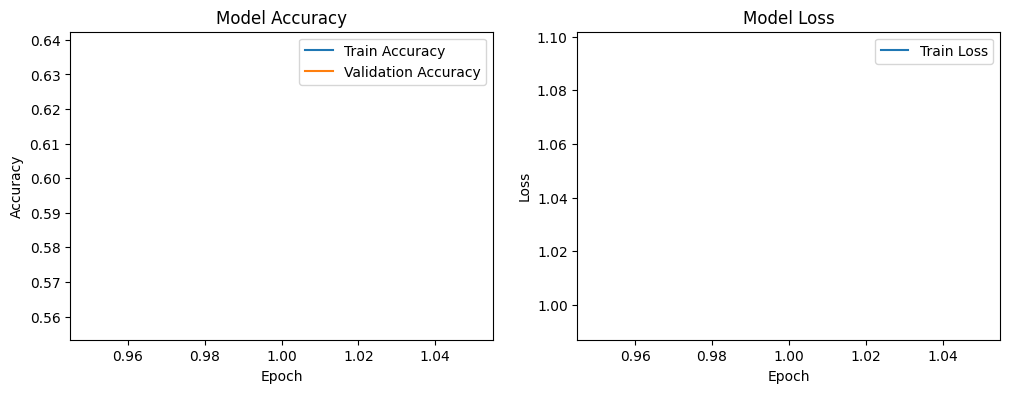

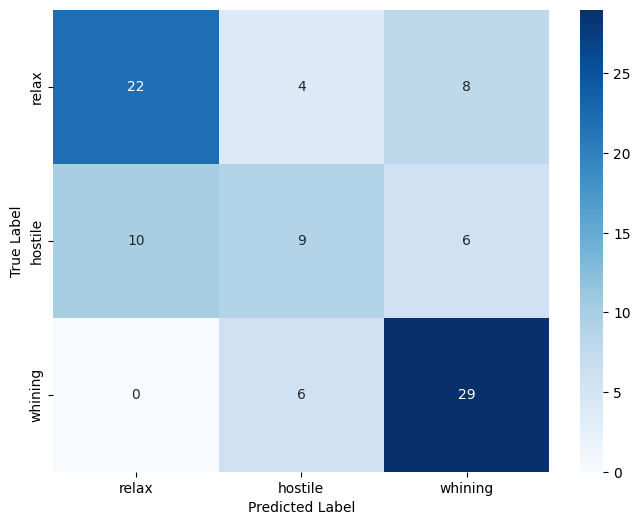

In [10]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=state_list, yticklabels=state_list)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()